## 📑 Índice

1. **Introducción**
2. **Importación de Librerías**
3. **Carga Inicial de los Datos**
4. **Análisis Exploratorio de Datos**
5. **Preparación de los Datos para Prophet**
6. **Modelado con Prophet y Evaluación del Modelo**
7. **Conclusiones y Recomendaciones**
8. **Anexos**

## 1. Introducción 

En este proyecto abordamos el problema de predicción de demanda en tiendas utilizando modelos de series temporales. Específicamente, aplicamos el modelo **Prophet** desarrollado por Facebook, que permite capturar tendencias, estacionalidades (diarias, semanales, anuales) y efectos de días festivos, siendo una herramienta ideal para datos de retail.  
Nuestro objetivo principal es prever la demanda futura por tienda y productos, lo que puede ayudar a tomar decisiones informadas en logística, inventario y campañas de marketing.

A lo largo del análisis, responderemos preguntas como:

- ¿Cuál es el comportamiento estacional de las ventas?
- ¿Qué tendencias existen a lo largo del tiempo?
- ¿Cómo se puede anticipar la demanda futura a partir del historial disponible?

## 2. Importación de Librerías

In [1]:
# Manipulación de datos
import pandas as pd
import numpy as np

In [2]:
# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Modelado
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from prophet import Prophet

Importing plotly failed. Interactive plots will not work.


In [4]:
# Validación y métricas
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [5]:
# Diseño
from tqdm import tqdm 
import warnings
warnings.filterwarnings('ignore')

## 3. Carga Inicial de los Datos

In [6]:
# Carga de archivos CSV
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [7]:
# Convertir la columna 'date' a tipo datetime
train['date'] = pd.to_datetime(train['date'])
test['date'] = pd.to_datetime(test['date'])

## 4. Análisis Exploratorio de Datos

In [8]:
# Vista general de los datasets
print("Train shape:", train.shape)
print("Test shape:", test.shape)

Train shape: (913000, 4)
Test shape: (45000, 4)


In [9]:
# Primeras filas
train.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [10]:
test.head()

,id,date,store,item
0,0,2018-01-01,1,1
1,1,2018-01-02,1,1
2,2,2018-01-03,1,1
3,3,2018-01-04,1,1
4,4,2018-01-05,1,1


In [11]:
# Ordenamos por fecha
train = train.sort_values('date')
train

,date,store,item,sales
0,2013-01-01,1,1,13
211816,2013-01-01,7,12,26
832656,2013-01-01,7,46,27
213642,2013-01-01,8,12,54
215468,2013-01-01,9,12,35
...,...,...,...,...
619013,2017-12-31,9,34,21
620839,2017-12-31,10,34,32
622665,2017-12-31,1,35,55
598927,2017-12-31,8,33,100


In [12]:
# Buscamos filas duplicados
print("Filas duplicadas:", train.duplicated().sum())

Filas duplicadas: 0


In [13]:
# Buscamos valores nulos
print("Valores nulos:")
train.isna().sum()

Valores nulos:


date     0
store    0
item     0
sales    0
dtype: int64

In [14]:
print("Información de train:")
train.info()

Información de train:
<class 'pandas.core.frame.DataFrame'>
Index: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    913000 non-null  datetime64[ns]
 1   store   913000 non-null  int64         
 2   item    913000 non-null  int64         
 3   sales   913000 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 34.8 MB


In [15]:
print("\nDescripción estadística:")
train.describe()


Descripción estadística:


,date,store,item,sales
count,913000,913000.000000,913000.000000,913000.000000
mean,2015-07-02 12:00:00.000000256,5.500000,25.500000,52.250287
min,2013-01-01 00:00:00,1.000000,1.000000,0.000000
25%,2014-04-02 00:00:00,3.000000,13.000000,30.000000
50%,2015-07-02 12:00:00,5.500000,25.500000,47.000000
75%,2016-10-01 00:00:00,8.000000,38.000000,70.000000
max,2017-12-31 00:00:00,10.000000,50.000000,231.000000
std,NaN,2.872283,14.430878,28.801144


In [16]:
print("\nFecha mínima:", train['date'].min())
print("Fecha máxima:", train['date'].max())


Fecha mínima: 2013-01-01 00:00:00
Fecha máxima: 2017-12-31 00:00:00


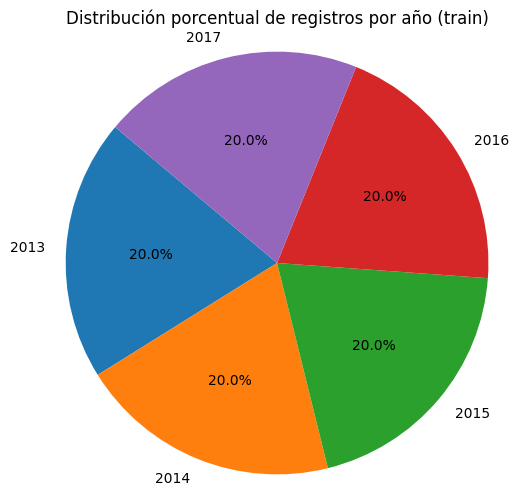

In [17]:
# Porcentaje de registros por año
train['year'] = train['date'].dt.year
year_distribution = train['year'].value_counts(normalize=True).sort_index() * 100

# Gráfico circular
plt.figure(figsize=(6, 6))
plt.pie(year_distribution, labels=year_distribution.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribución porcentual de registros por año (train)')
plt.axis('equal')
plt.show()


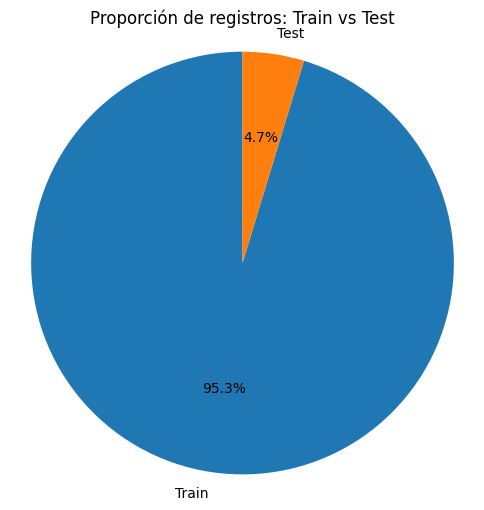

In [18]:
train_size = len(train)
test_size = len(test)
total_size = train_size + test_size

sizes = [train_size, test_size]
labels = ['Train', 'Test']
percentages = [s / total_size * 100 for s in sizes]

# Gráfico circular
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title('Proporción de registros: Train vs Test')
plt.axis('equal')
plt.show()


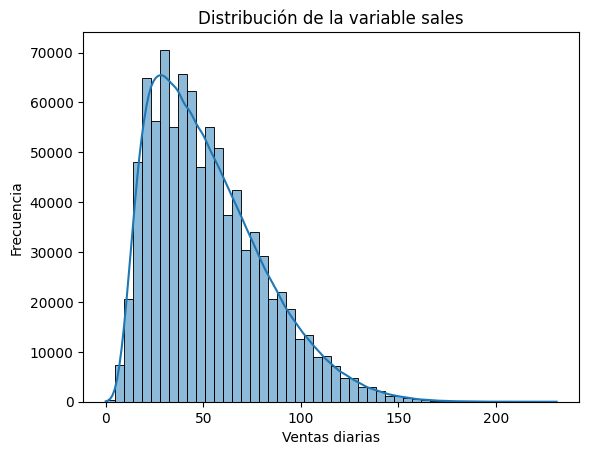

In [19]:
# Distribución de ventas
plt.figure()
sns.histplot(train['sales'], bins=50, kde=True)
plt.title('Distribución de la variable sales')
plt.xlabel('Ventas diarias')
plt.ylabel('Frecuencia')
plt.show()

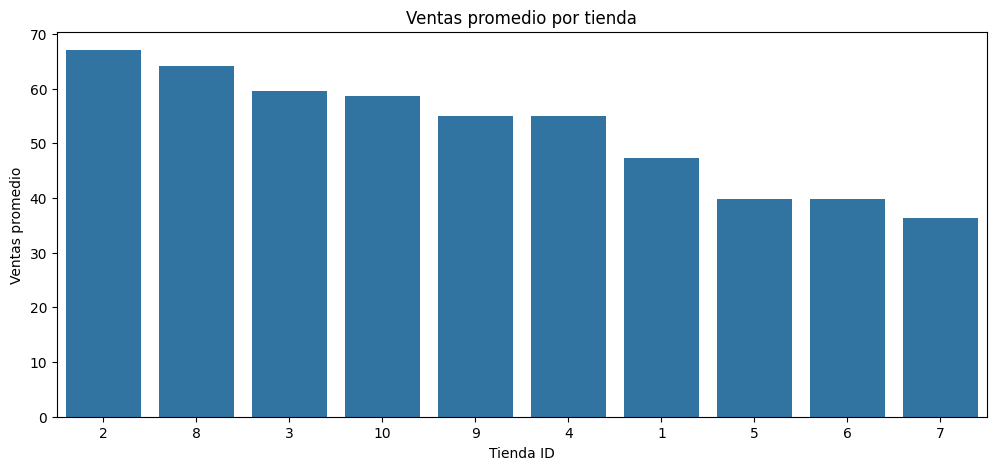

In [20]:
# Ventas promedio por tienda
store_avg = train.groupby('store')['sales'].mean().reset_index()

# Ordenamos el DataFrame por las ventas promedio de mayor a menor
store_avg_sorted = store_avg.sort_values(by='sales', ascending=False)

# Graficamos
plt.figure(figsize=(12, 5))
sns.barplot(x='store', y='sales', data=store_avg_sorted, order=store_avg_sorted['store'])
plt.title('Ventas promedio por tienda')
plt.xlabel('Tienda ID')
plt.ylabel('Ventas promedio')
plt.show()

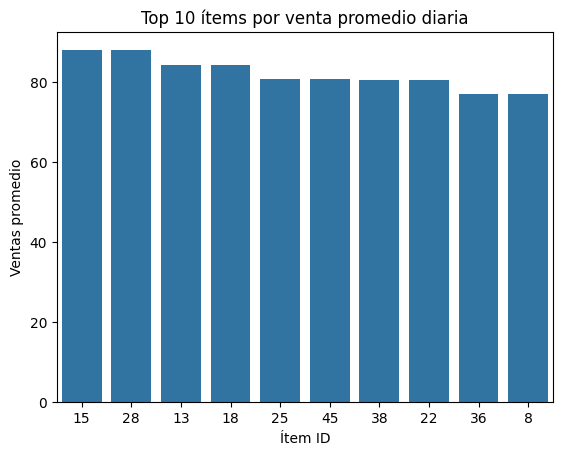

In [21]:
# Ventas promedio por ítem
top_items = train.groupby('item')['sales'].mean().sort_values(ascending=False).head(10)

plt.figure()
sns.barplot(
    x=top_items.index.astype(str), 
    y=top_items.values, 
    order=top_items.index.astype(str)
)
plt.title('Top 10 ítems por venta promedio diaria')
plt.xlabel('Ítem ID')
plt.ylabel('Ventas promedio')
plt.show()

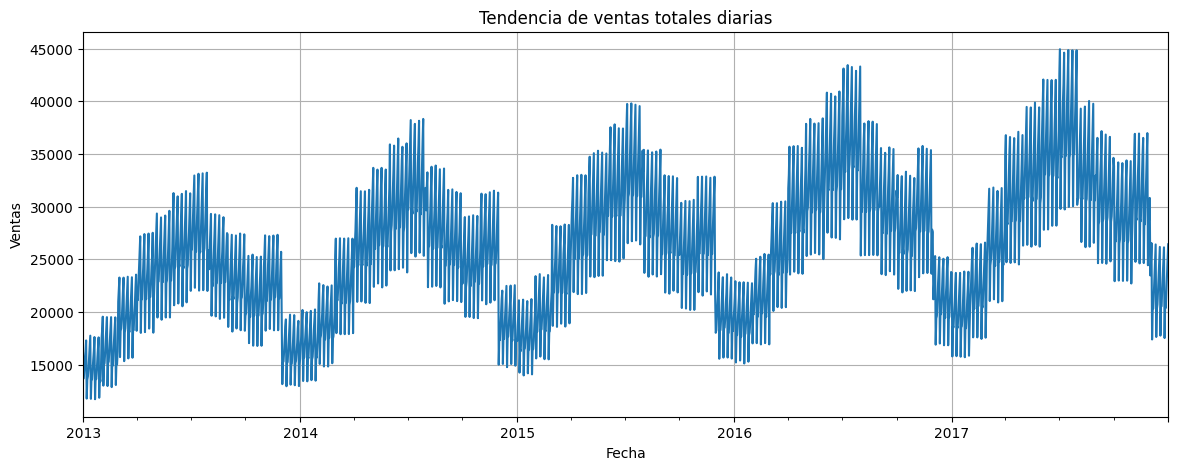

In [22]:
# Ventas diarias totales
daily_sales = train.groupby('date')['sales'].sum()

# Graficar
plt.figure(figsize=(14, 5))
daily_sales.plot()
plt.title('Tendencia de ventas totales diarias')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.grid(True)
plt.show()


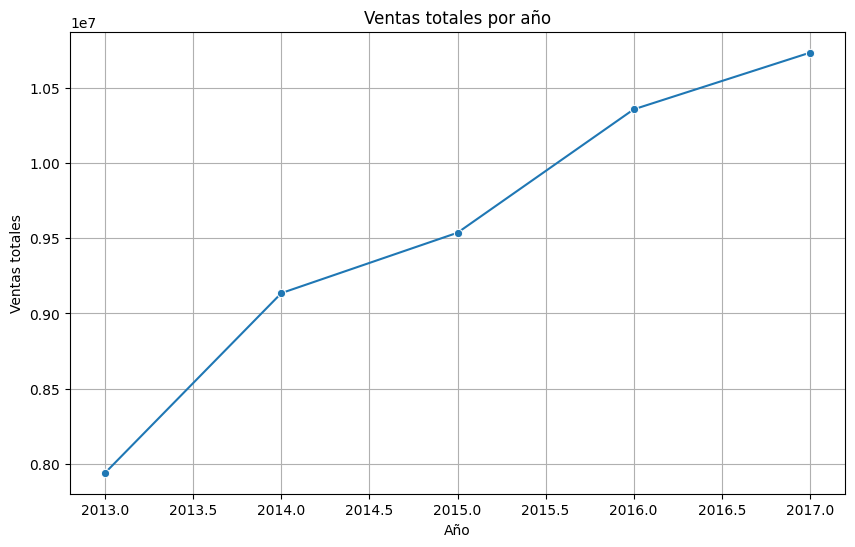

In [23]:
# Ventas por Año
sales_by_year = train.groupby('year')['sales'].sum()

# Graficamos
plt.figure(figsize=(10, 6))
sns.lineplot(x=sales_by_year.index.astype(int), y=sales_by_year.values, marker='o')
plt.title('Ventas totales por año')
plt.xlabel('Año')
plt.ylabel('Ventas totales')
plt.grid(True)
plt.show()


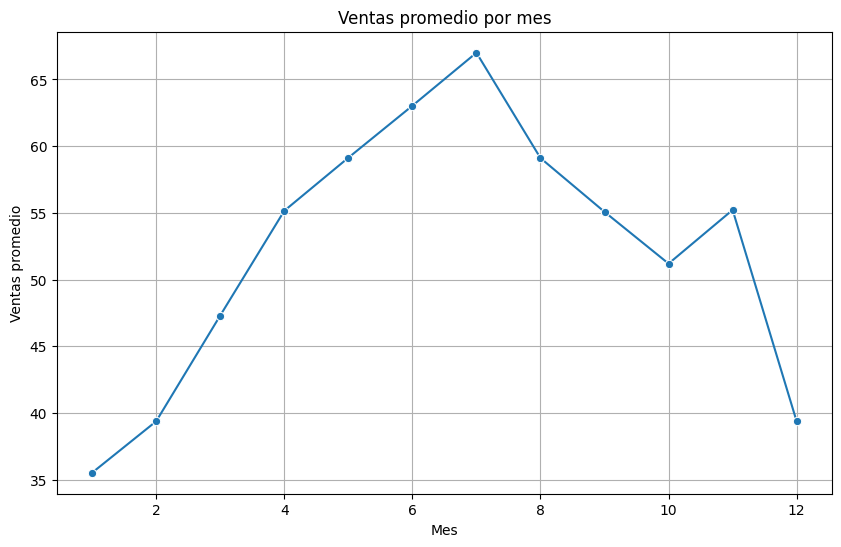

In [24]:
# Extraer mes
train['month'] = train['date'].dt.month

# Ventas promedio por mes
avg_sales_by_month = train.groupby('month')['sales'].mean()

plt.figure(figsize=(10, 6))
sns.lineplot(x=avg_sales_by_month.index, y=avg_sales_by_month.values, marker='o')
plt.title('Ventas promedio por mes')
plt.xlabel('Mes')
plt.ylabel('Ventas promedio')
plt.grid(True)
plt.show()


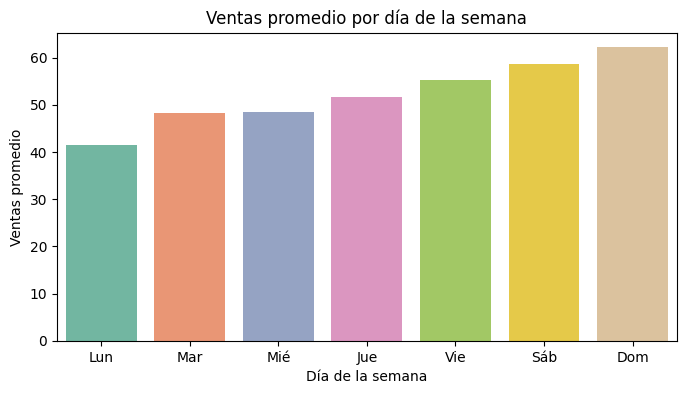

In [25]:
# Ventas por día de la semana
train['weekday'] = train['date'].dt.weekday

# Promedio de ventas por día
weekday_avg = train.groupby('weekday')['sales'].mean()

# Gráfico
plt.figure(figsize=(8, 4))
sns.barplot(x=weekday_avg.index, y=weekday_avg.values, palette='Set2')
plt.title('Ventas promedio por día de la semana')
plt.xlabel('Día de la semana')
plt.ylabel('Ventas promedio')
plt.xticks(ticks=range(7), labels=['Lun', 'Mar', 'Mié', 'Jue', 'Vie', 'Sáb', 'Dom'])
plt.show()


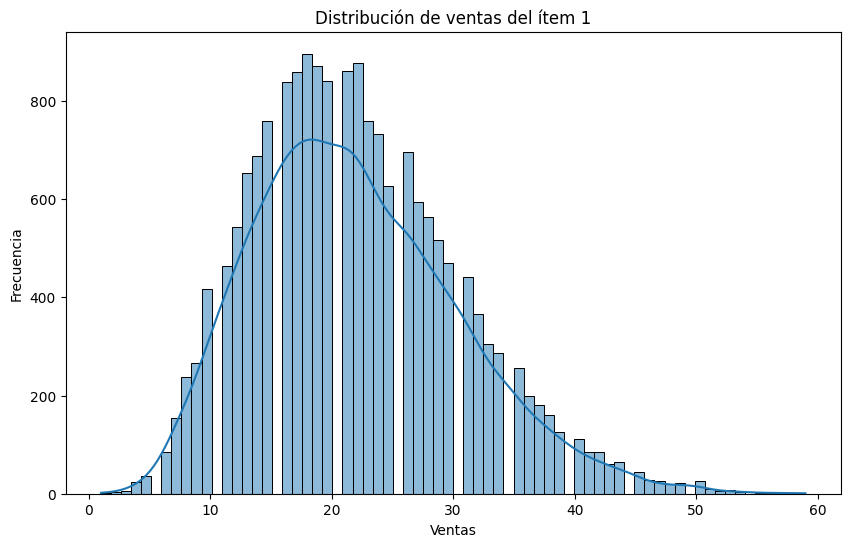

In [26]:
item_sales_dist = train[train['item'] == 1]['sales']  # Aquí puedes poner el item que desees
plt.figure(figsize=(10, 6))
sns.histplot(item_sales_dist, kde=True)
plt.title('Distribución de ventas del ítem 1')
plt.xlabel('Ventas')
plt.ylabel('Frecuencia')
plt.show()

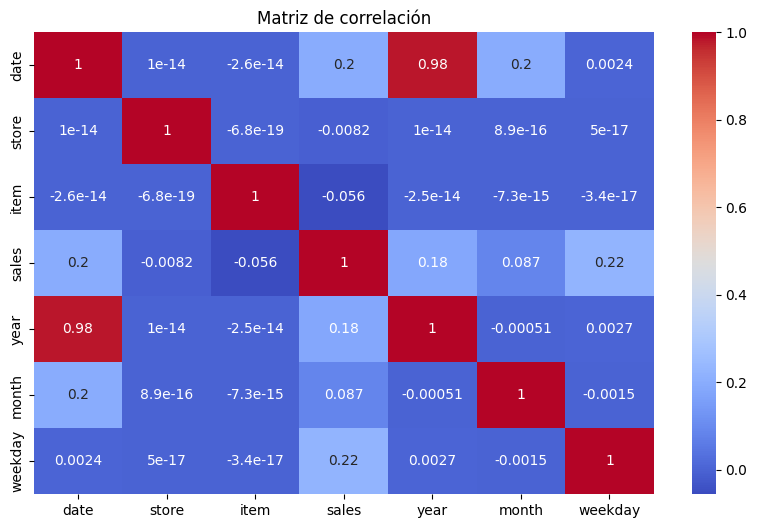

In [27]:
# Correlación de Variables
corr = train.corr()

plt.figure(figsize=(10, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Matriz de correlación')
plt.show()

In [28]:
corr

,date,store,item,sales,year,month,weekday
date,1.000000e+00,1.009177e-14,-2.584095e-14,0.195909,9.797959e-01,1.988030e-01,2.373485e-03
store,1.009177e-14,1.000000e+00,-6.774332e-19,-0.008170,1.011427e-14,8.890949e-16,4.985634e-17
item,-2.584095e-14,-6.774332e-19,1.000000e+00,-0.055998,-2.494470e-14,-7.292755e-15,-3.386967e-17
sales,1.959089e-01,-8.170361e-03,-5.599807e-02,1.000000,1.823597e-01,8.741417e-02,2.226076e-01
year,9.797959e-01,1.011427e-14,-2.494470e-14,0.182360,1.000000e+00,-5.080291e-04,2.711688e-03
month,1.988030e-01,8.890949e-16,-7.292755e-15,0.087414,-5.080291e-04,1.000000e+00,-1.475063e-03
weekday,2.373485e-03,4.985634e-17,-3.386967e-17,0.222608,2.711688e-03,-1.475063e-03,1.000000e+00


## 5. Preparación de los Datos para Prophet

In [29]:
# Convertir la columna 'date' a tipo datetime
train['date'] = pd.to_datetime(train['date'])

# Establecer la columna 'date' como índice del DataFrame
train.set_index('date', inplace=True)


In [30]:
# Agrupar las ventas por fecha (agregación diaria)
train_daily = train.groupby('date')['sales'].sum()

# Visualizar las primeras filas para ver la estructura
train_daily.head()

date
2013-01-01    13696
2013-01-02    13678
2013-01-03    14488
2013-01-04    15677
2013-01-05    16237
Name: sales, dtype: int64

In [31]:
# Asegurar que la serie tenga frecuencia diaria continua
train_daily.index = pd.to_datetime(train_daily.index)
train_daily = train_daily.asfreq('D')

In [32]:
# Aplicar prueba de Dickey-Fuller aumentada (ADF) para evaluar la estacionariedad de la serie
# A pesar de que Prophet no requiere estacionariedad, es útil para conocer la naturaleza de la serie (puede servir para otros modelos)
adf_result = adfuller(train_daily)

# Mostrar los resultados
print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")
for key, value in adf_result[4].items():
    print(f"Critical Value {key}: {value}")

ADF Statistic: -3.060244118701348
p-value: 0.029638649268843572
Critical Value 1%: -3.4339800605797155
Critical Value 5%: -2.8631434696839992
Critical Value 10%: -2.5676236347535166


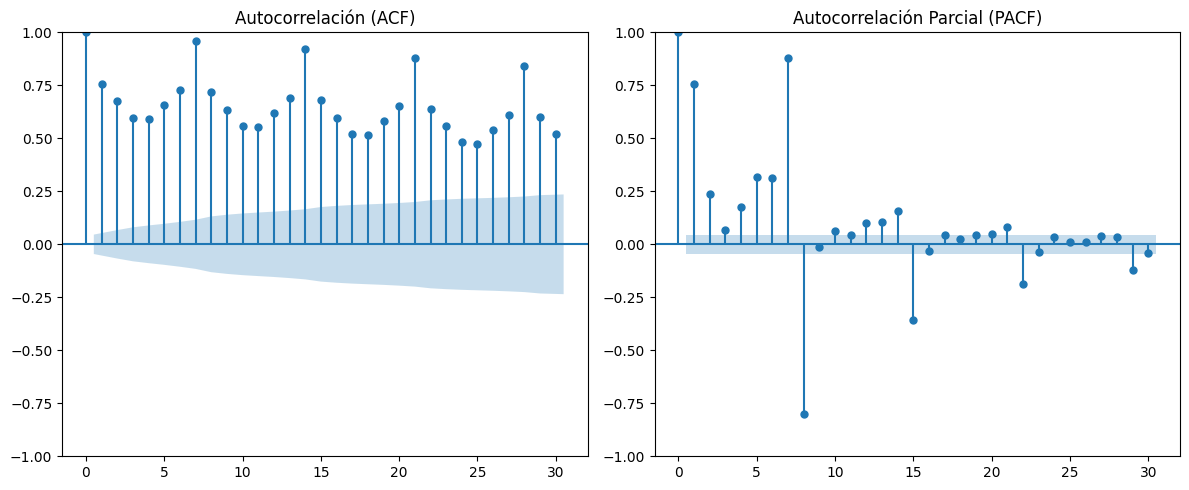

In [33]:
# Visualización de autocorrelación y autocorrelación parcial para detectar patrones estacionales
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plot_acf(train_daily, lags=30, ax=plt.gca())
plt.title('Autocorrelación (ACF)')

plt.subplot(1, 2, 2)
plot_pacf(train_daily, lags=30, ax=plt.gca())
plt.title('Autocorrelación Parcial (PACF)')

plt.tight_layout()
plt.show()

## 6.  Modelado con Prophet y Evaluación del Modelo

In [34]:
# Prophet requiere que las columnas se llamen 'ds' para fechas y 'y' para valores
train_daily_df = train_daily.reset_index()
train_daily_df = train_daily_df.rename(columns={'date': 'ds', 'sales': 'y'})

16:26:55 - cmdstanpy - INFO - Chain [1] start processing
16:26:56 - cmdstanpy - INFO - Chain [1] done processing


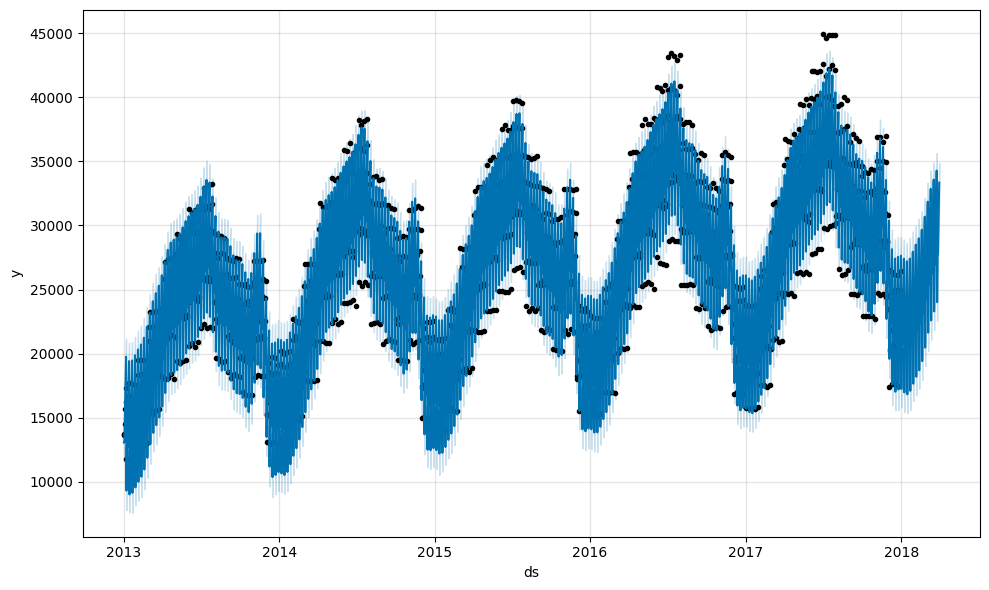

In [35]:
# Crear y ajustar el modelo Prophet
model = Prophet()
model.fit(train_daily_df)

# Crear fechas futuras para predicción (90 días adelante)
future = model.make_future_dataframe(periods=90)

# Hacer predicciones
forecast = model.predict(future)

# Visualizar la predicción completa con los datos históricos
model.plot(forecast);

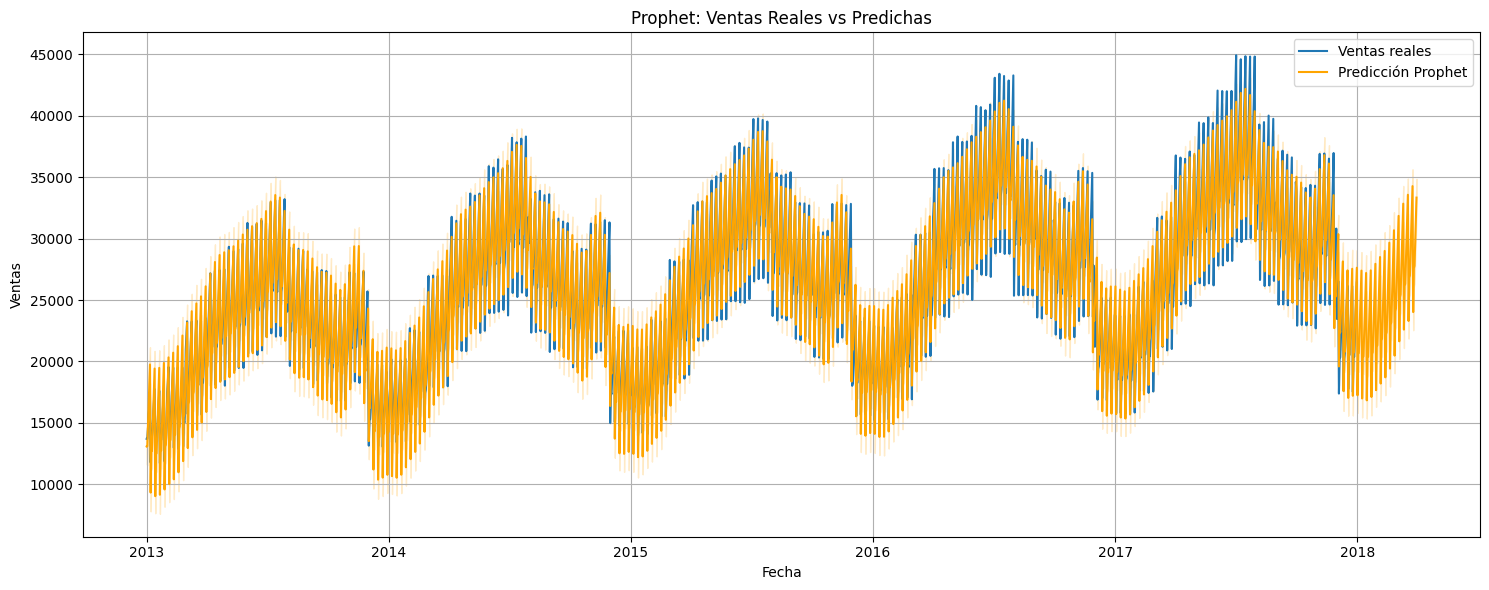

In [36]:
# Visualizar comparación de ventas reales vs predicciones de Prophet
plt.figure(figsize=(15, 6))

# Datos reales
plt.plot(train_daily.index, train_daily.values, label='Ventas reales')

# Predicción de Prophet
plt.plot(forecast['ds'], forecast['yhat'], label='Predicción Prophet', color='orange')

# Banda de incertidumbre (opcional)
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='orange', alpha=0.2)

plt.title('Prophet: Ventas Reales vs Predichas')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

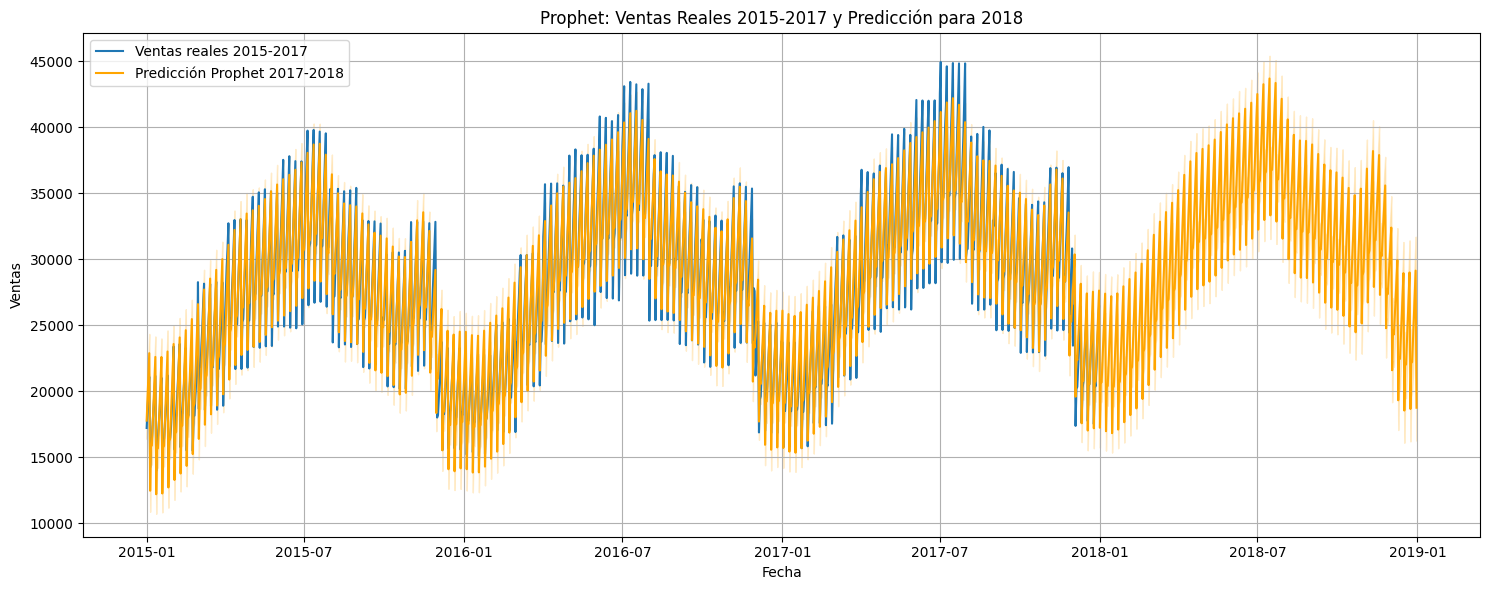

In [37]:
# Crear fechas futuras para predecir un año adicional (365 días)
future = model.make_future_dataframe(periods=365)

# Hacer nuevas predicciones
forecast = model.predict(future)

# Definir rango de interés
start_2017 = '2015-01-01'
end_2018 = '2018-12-31'

# Filtrar predicciones para ese rango
forecast_2017_2018 = forecast[(forecast['ds'] >= start_2017) & (forecast['ds'] <= end_2018)]

# Filtrar datos reales (hasta 2017 únicamente)
real_2017 = train_daily[start_2017:end_2018]

# Visualización
plt.figure(figsize=(15, 6))
plt.plot(real_2017.index, real_2017.values, label='Ventas reales 2015-2017')
plt.plot(forecast_2017_2018['ds'], forecast_2017_2018['yhat'], label='Predicción Prophet 2017-2018', color='orange')

# Banda de incertidumbre
plt.fill_between(forecast_2017_2018['ds'],
                 forecast_2017_2018['yhat_lower'],
                 forecast_2017_2018['yhat_upper'],
                 color='orange', alpha=0.2)

plt.title('Prophet: Ventas Reales 2015-2017 y Predicción para 2018')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

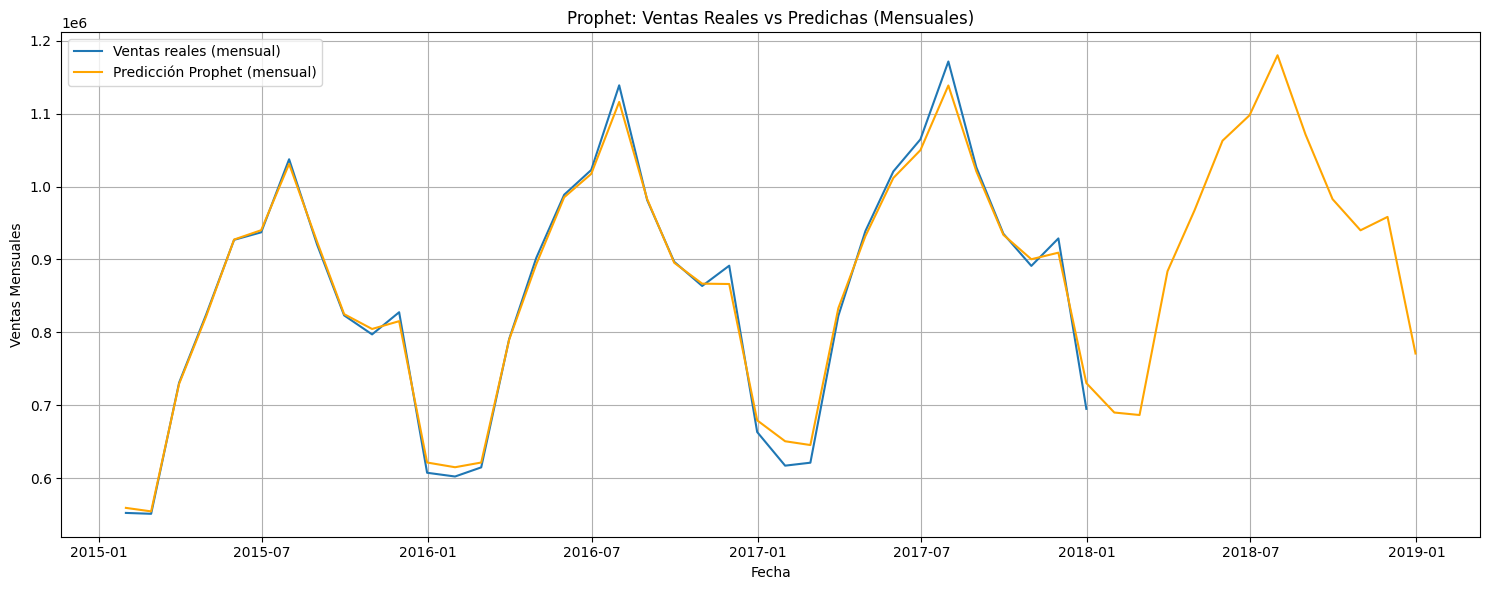

In [38]:
# Agregar ventas reales por mes (hasta 2017)
real_2017_monthly = train_daily[start_2017:end_2018].resample('M').sum()

# Agregar predicciones por mes
forecast_2017_2018_monthly = forecast_2017_2018.set_index('ds')['yhat'].resample('M').sum()

# Visualización mensual
plt.figure(figsize=(15, 6))
plt.plot(real_2017_monthly.index, real_2017_monthly.values, label='Ventas reales (mensual)')
plt.plot(forecast_2017_2018_monthly.index, forecast_2017_2018_monthly.values, label='Predicción Prophet (mensual)', color='orange')

plt.title('Prophet: Ventas Reales vs Predichas (Mensuales)')
plt.xlabel('Fecha')
plt.ylabel('Ventas Mensuales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [39]:
forecast_eval = forecast.set_index('ds').loc[train_daily.index]
mae = mean_absolute_error(train_daily, forecast_eval['yhat'])
mse = mean_squared_error(train_daily, forecast_eval['yhat'])
rmse = np.sqrt(mse)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

MAE: 890.65
RMSE: 1153.94


### Evaluación del Modelo

En este paso, se calculan dos métricas clave para evaluar el desempeño del modelo Prophet: **MAE (Error Absoluto Medio)** y **RMSE (Raíz del Error Cuadrático Medio)**.

- **MAE** (Mean Absolute Error): Mide el promedio de las diferencias absolutas entre las predicciones del modelo y los valores reales. Un MAE más bajo indica que las predicciones del modelo están más cerca de los valores reales. En este caso, un MAE de `890.65` significa que, en promedio, el modelo cometió un error de aproximadamente `890.65` unidades en las ventas diarias.

- **RMSE** (Root Mean Squared Error): Mide la raíz cuadrada del promedio de los errores al cuadrar las diferencias entre las predicciones y los valores reales. Este valor penaliza los errores más grandes, lo que significa que es más sensible a los valores atípicos. Un RMSE de `1153.94` sugiere que, aunque el modelo es bastante preciso en general, hay algunos errores que son más grandes de lo esperado. Sin embargo, en relación con la magnitud de las ventas diarias, el error es moderado.

Aunque estos resultados indican que el modelo tiene un buen desempeño, es importante seguir monitorizando su rendimiento y realizar ajustes si es necesario, especialmente en presencia de valores atípicos o patrones estacionales que el modelo podría no estar capturando completamente.

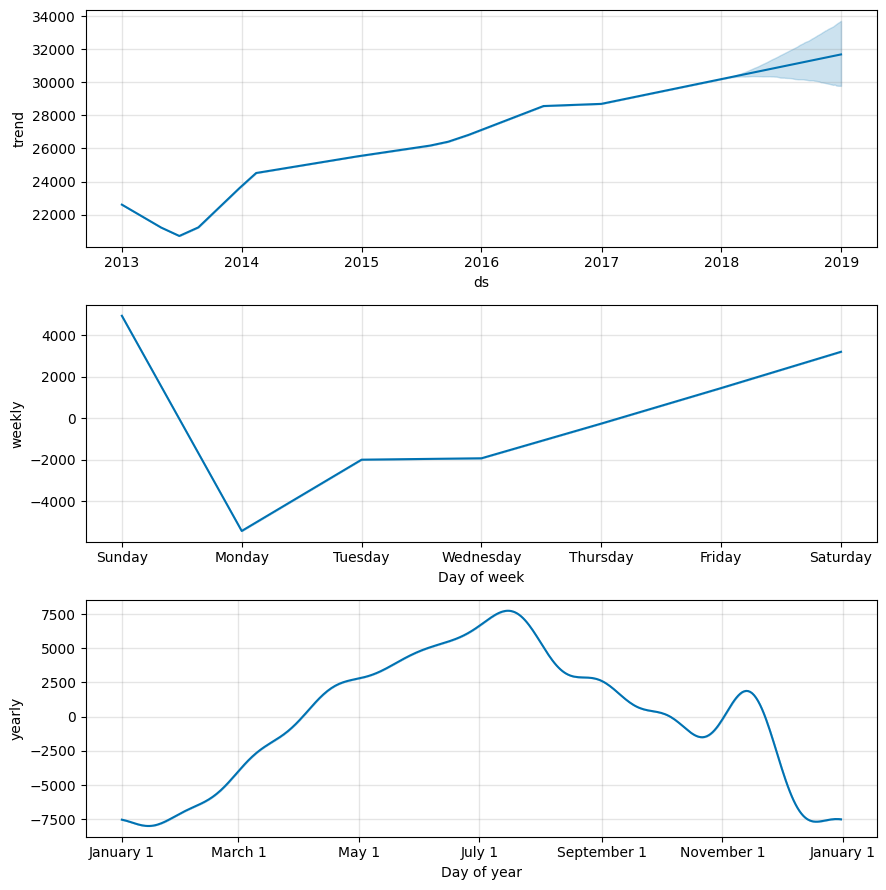

In [40]:
model.plot_components(forecast);

### Análisis de Componentes del Modelo Prophet

Al utilizar la función `model.plot_components(forecast)`, hemos desglosado las principales contribuciones que afectan a las predicciones del modelo Prophet. Esta visualización permite analizar los siguientes componentes:

- **Tendencia**: Muestra la evolución general de las ventas a lo largo del tiempo. En esta sección, se puede observar una tendencia creciente en las ventas, lo cual es clave para entender el comportamiento a largo plazo del negocio.
  
- **Estacionalidad**: Representa las fluctuaciones recurrentes en las ventas, como patrones diarios, semanales o anuales. Por ejemplo, en el contexto del retail, las ventas podrían aumentar los fines de semana o durante fechas especiales. La gráfica de estacionalidad ayuda a identificar estos patrones y permite validar si el modelo está capturando correctamente la variabilidad en las ventas debido a la estacionalidad.

En resumen, esta visualización ofrece una interpretación detallada de cómo las diferentes componentes (tendencia, estacionalidad) afectan las predicciones del modelo. Permite realizar ajustes si es necesario, especialmente si observamos patrones de comportamiento no capturados correctamente por el modelo, lo cual puede ser útil para mejorar la precisión de las predicciones en futuros análisis.


In [41]:
forecast.to_csv('forecast_prophet.csv', index=False)

### Análisis por Tienda y Producto

In [42]:
# Crear un DataFrame vacío para almacenar predicciones
all_forecasts = []

In [43]:
# Iterar por cada combinación de tienda y producto
stores = train['store'].unique()
items = train['item'].unique()

In [44]:
for store in tqdm(stores, desc='Stores'):
    for item in items:
        # Filtrar datos para la combinación tienda-producto
        df = train[(train['store'] == store) & (train['item'] == item)]

        # Agrupar por fecha y sumar ventas
        df_grouped = df.groupby('date')['sales'].sum().reset_index()

        # Renombrar columnas para Prophet
        df_grouped = df_grouped.rename(columns={'date': 'ds', 'sales': 'y'})

        # Evitar series vacías o demasiado cortas
        if len(df_grouped) < 100:
            continue

        # Crear y entrenar el modelo
        model = Prophet()
        model.fit(df_grouped)

        # Generar fechas futuras (3 meses = 90 días)
        future = model.make_future_dataframe(periods=90)

        # Predecir
        forecast = model.predict(future)

        # Seleccionar columnas necesarias y agregar store/item
        forecast_subset = forecast[['ds', 'yhat']].copy()
        forecast_subset['store'] = store
        forecast_subset['item'] = item

        # Guardar predicciones
        all_forecasts.append(forecast_subset)

Stores:   0%|                                                                                   | 0/10 [00:00<?, ?it/s]16:26:59 - cmdstanpy - INFO - Chain [1] start processing
16:26:59 - cmdstanpy - INFO - Chain [1] done processing
16:27:00 - cmdstanpy - INFO - Chain [1] start processing
16:27:00 - cmdstanpy - INFO - Chain [1] done processing
16:27:01 - cmdstanpy - INFO - Chain [1] start processing
16:27:01 - cmdstanpy - INFO - Chain [1] done processing
16:27:01 - cmdstanpy - INFO - Chain [1] start processing
16:27:02 - cmdstanpy - INFO - Chain [1] done processing
16:27:02 - cmdstanpy - INFO - Chain [1] start processing
16:27:02 - cmdstanpy - INFO - Chain [1] done processing
16:27:03 - cmdstanpy - INFO - Chain [1] start processing
16:27:03 - cmdstanpy - INFO - Chain [1] done processing
16:27:04 - cmdstanpy - INFO - Chain [1] start processing
16:27:04 - cmdstanpy - INFO - Chain [1] done processing
16:27:05 - cmdstanpy - INFO - Chain [1] start processing
16:27:05 - cmdstanpy - INFO - Cha

In [45]:
total_forecast = pd.concat(all_forecasts)

In [46]:
total_forecast = total_forecast[['ds', 'store', 'item', 'yhat']]

In [47]:
print(total_forecast.head())

          ds  store  item       yhat
0 2013-01-01      1     1   8.646726
1 2013-01-02      1     1   9.306336
2 2013-01-03      1     1   9.983400
3 2013-01-04      1     1  11.548046
4 2013-01-05      1     1  13.491892


In [48]:
# Combinar todos los DataFrames de predicción en uno solo
all_forecasts_df = pd.concat(all_forecasts, ignore_index=True)

# Asegurarse de que 'train' tiene el índice como columna
train_reset = train.reset_index()

# Renombrar columna para que coincida con Prophet
train_reset = train_reset.rename(columns={'date': 'ds', 'sales': 'actual'})

# Unir predicciones con datos reales
real_vs_pred = pd.merge(all_forecasts_df, train_reset, on=['ds', 'store', 'item'], how='left')

# Calcular errores absolutos y porcentuales
real_vs_pred['abs_error'] = abs(real_vs_pred['actual'] - real_vs_pred['yhat'])
real_vs_pred['pct_error'] = abs(real_vs_pred['actual'] - real_vs_pred['yhat']) / real_vs_pred['actual']

# Reordenar columnas mostrar valores y predicción al final
cols = [col for col in real_vs_pred.columns if col not in ['actual', 'yhat', 'abs_error', 'pct_error']]
cols += ['actual', 'yhat', 'abs_error', 'pct_error']
real_vs_pred = real_vs_pred[cols]

# Vemos el resultado
real_vs_pred.head()


,ds,store,item,year,month,weekday,actual,yhat,abs_error,pct_error
0,2013-01-01,1,1,2013.0,1.0,1.0,13.0,8.646726,4.353274,0.334867
1,2013-01-02,1,1,2013.0,1.0,2.0,11.0,9.306336,1.693664,0.153969
2,2013-01-03,1,1,2013.0,1.0,3.0,14.0,9.983400,4.016600,0.286900
3,2013-01-04,1,1,2013.0,1.0,4.0,13.0,11.548046,1.451954,0.111689
4,2013-01-05,1,1,2013.0,1.0,5.0,10.0,13.491892,3.491892,0.349189


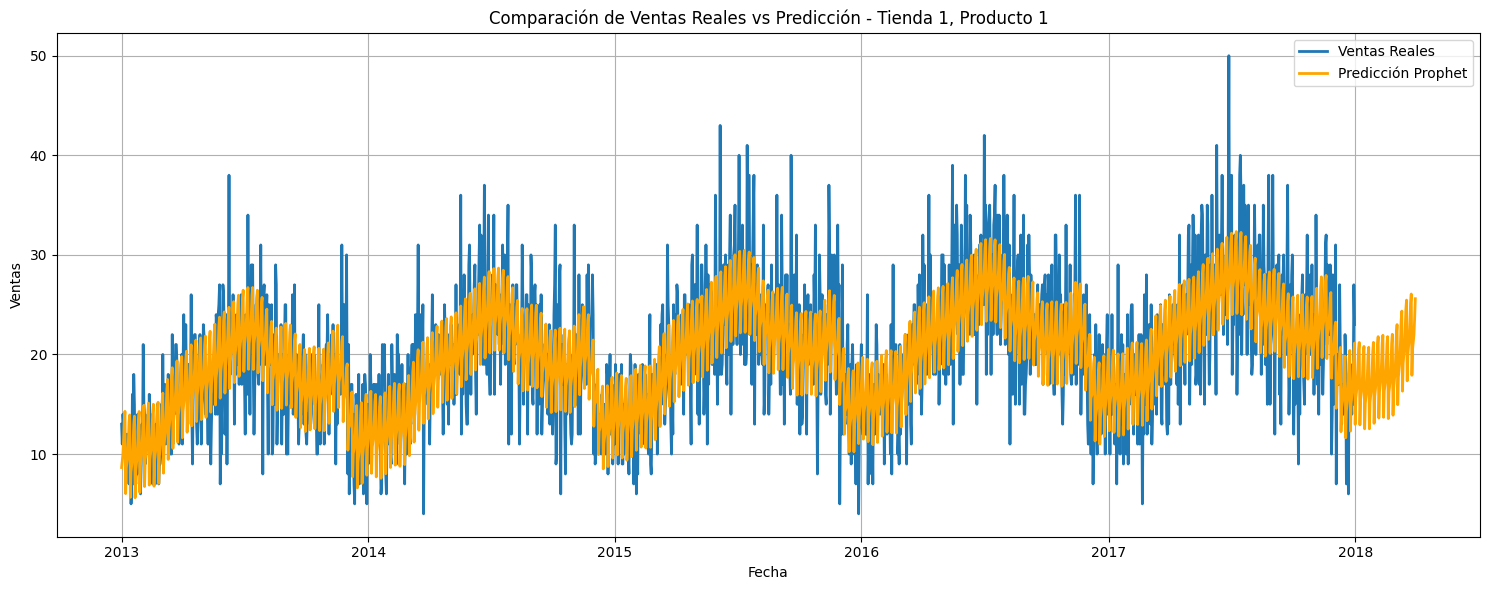

In [49]:
# Comparativo predicciones vs real con tienda y producto
# Elegir tienda y producto
store_id = 1
item_id = 1

# Filtrar los datos para esa combinación
df_plot = real_vs_pred[(real_vs_pred['store'] == store_id) & (real_vs_pred['item'] == item_id)].copy()

# Ordenar por fecha por si acaso
df_plot = df_plot.sort_values('ds')

# Crear gráfico
plt.figure(figsize=(15, 6))
plt.plot(df_plot['ds'], df_plot['actual'], label='Ventas Reales', linewidth=2)
plt.plot(df_plot['ds'], df_plot['yhat'], label='Predicción Prophet', linewidth=2, color='orange')

plt.title(f'Comparación de Ventas Reales vs Predicción - Tienda {store_id}, Producto {item_id}')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [50]:
# Guardar el DataFrame final en un archivo CSV
real_vs_pred.to_csv('ventas_predicciones_vs_reales.csv', index=False, encoding='utf-8')

## 7. Conclusiones

Este análisis de pronóstico de ventas utilizando el modelo Prophet ha permitido obtener valiosos insights sobre el comportamiento de ventas en distintas tiendas y productos. A lo largo del proceso, se abordaron cuestiones clave que impactan directamente en la toma de decisiones comerciales, como la estacionalidad y la forma en que las tiendas deben ser modeladas.

### Metodología y Herramientas Utilizadas

- **Lenguaje de programación:** Python.
- **Librerías utilizadas:** pandas, matplotlib, seaborn, numpy, Prophet.
- **Técnicas aplicadas:** Limpieza y transformación de datos, modelado de series temporales, análisis de tendencias y patrones, visualización de componentes.
- **Tipo de gráficos:** Gráficos de líneas, barras y componentes estacionales, utilizados para facilitar la interpretación visual de los resultados.

### Principales Hallazgos

- **Estacionalidad:** Se identificaron patrones estacionales marcados en los datos, como el aumento de ventas en ciertas estaciones del año. Esto se modeló efectivamente con Prophet utilizando los componentes estacionales automáticos.
- **Diferencias entre tiendas y productos:** Cada tienda y producto tiene su propio comportamiento, lo que hace que el modelado por separado sea más preciso en comparación con el enfoque agregado.
- **Optimización de recursos:** Agrupar tiendas o productos en un solo modelo puede reducir el costo computacional, pero a veces sacrifica la capacidad de capturar patrones específicos.

### Impacto del Análisis

Gracias a este análisis, se respondieron preguntas clave del negocio relacionadas con:

- **Segmentación:** Identificación de tendencias estacionales y comportamientos específicos por tienda y producto.
- **Temporadas de alta y baja venta:** Posibilidad de ajustar inventarios y estrategias de ventas según las estaciones del año y los días de la semana.
- **Optimización de promociones y stock:** Ajustes específicos para cada tienda y producto basados en su comportamiento histórico.

Este análisis puede ser la base para modelos más avanzados de predicción o recomendaciones personalizadas, y puede aportar valor directo en la toma de decisiones estratégicas para la gestión de ventas y el marketing.

### ¿Cuál es la mejor manera de tratar la estacionalidad?

En series temporales, la **estacionalidad** se refiere a patrones o ciclos recurrentes en los datos (por ejemplo, semanales o anuales). Prophet maneja la estacionalidad de manera muy efectiva y automática gracias a su soporte integrado para:

- **Estacionalidad anual**
- **Estacionalidad semanal**

Para tratar la estacionalidad de la mejor manera posible, se puede: 

**Usar los componentes estacionales integrados de Prophet:**  
Prophet modela automáticamente la estacionalidad semanal y anual. Estos componentes se pueden visualizar con `model.plot_components(forecast)` para entender su impacto a lo largo del tiempo.

### 🏬 ¿Deberían modelarse las tiendas por separado o pueden agruparse?

Una pregunta común en series temporales multivariadas es si conviene **modelar cada tienda individualmente** o si es posible **agruparlas (pooling)** en un solo modelo para ahorrar recursos computacionales o mejorar la generalización.

#### ✅ Modelar por separado
Modelar cada combinación de `store` e `item` de manera independiente tiene ventajas clave:
- Captura mejor la **estacionalidad y tendencias específicas** de cada tienda o producto.
- Permite ajustes personalizados y mejora la precisión.
- Evita promediar comportamientos distintos que pueden anular patrones importantes.

#### 🔁 Agrupamiento (pooling)
Agrupar múltiples tiendas o productos en un solo modelo puede:
- Reducir el costo computacional.
- Ayudar cuando hay **pocos datos por serie individual** (por ejemplo, tiendas nuevas).
- Ser útil para detectar **tendencias generales del negocio**, pero puede perder detalle.


### ⚙️ ¿Qué se hizo en este proyecto?

En este proyecto se probaron **ambas estrategias**:

1. ✅ **Modelo agregado:**  
   Inicialmente se entrenó un modelo Prophet sobre los datos agregados por día (`train_daily`) para evaluar tendencias generales y validar el enfoque.

2. 🧩 **Modelos por tienda y producto:**  
   Luego se optó por modelar cada combinación `store`-`item` por separado, ya que esto permitió capturar patrones únicos de estacionalidad y ventas. Prophet fue entrenado en bucle para cada serie individual, generando predicciones específicas y mejorando el desempeño global.

Esta segunda estrategia ofreció una mayor capacidad para personalizar los modelos según las características particulares de cada tienda y artículo, y resultó ser más adecuada para el objetivo del proyecto: **predecir ventas específicas de cada producto en cada tienda con mayor precisión**.

## 8. Anexos y Recursos

### Fuente de Datos
- **Dataset utilizado:** [Store Item Demand Forecasting Challenge](https://www.kaggle.com/competitions/demand-forecasting-kernels-only)  

### Herramientas Utilizadas
- **Python** para análisis de datos y visualización.
- **Librerías principales:**
  - `pandas`: para manipulación y análisis de datos tabulares.
  - `matplotlib` y `seaborn`: para visualización de datos.
  - `Prophet`: para modelado de series temporales y predicción de ventas.
  - `numpy`: para cálculos numéricos y agrupaciones.

### Notas Complementarias
- El dataset fue procesado para ajustarse al modelo de Prophet, transformando las columnas necesarias (fecha, ventas, tienda y artículo) para ajustarlas a la estructura que Prophet requiere (`ds` para fecha y `y` para las ventas).
- Se realizó un análisis exploratorio para identificar patrones de estacionalidad y tendencias en las ventas a lo largo del tiempo.
- Se utilizaron diferentes enfoques para modelar las ventas, tanto a nivel agregado como a nivel individual por tienda y artículo, para evaluar cuál estrategia proporcionaba las predicciones más precisas.


### Proyectos Relacionados
- En paralelo a este análisis, se desarrolló un **dashboard interactivo en Power BI** que visualiza tanto los datos históricos como las predicciones generadas con Prophet. Este dashboard permitirá a los usuarios explorar dinámicamente las predicciones de ventas por tienda y artículo, ofreciendo un enfoque más visual e interactivo para la toma de decisiones.


### Recomendaciones Técnicas Futuras
- **Optimización de modelos predictivos:** Mejorar la precisión de las predicciones mediante técnicas adicionales como la integración de datos externos (por ejemplo, datos sobre promociones o condiciones económicas).
- **Modelos adicionales:** Ampliar el análisis para incluir otras técnicas de predicción, como redes neuronales o modelos de machine learning avanzados, para comparar su desempeño con Prophet.
- **Análisis de segmentación:** Implementar segmentaciones adicionales de clientes y productos, utilizando técnicas como clustering, para obtener insights más específicos y personalizados sobre los patrones de compra.
